# Setup summary:

- numpy, pandas       # data manipulation
- matplotlib, seaborn # plotting & visualization
- cv2 (OpenCV)        # image processing
- os, random          # filesystem & randomness
- sklearn             # preprocessing & model utils
- keras (tensorflow)  # deep learning model building
- %matplotlib inline  # inline plotting in notebook


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
from os import listdir
from sklearn.preprocessing import  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import random
import matplotlib.image as mpimg
%matplotlib inline

2025-05-21 19:54:15.214595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747857255.237967    6566 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747857255.245163    6566 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_path="/kaggle/input/birds-species-prediction/Data/Bird Speciees Dataset/"


# 🐦 Bird Species Prediction — Sample Images

---

**Displaying 25 random bird images** from the dataset, each labeled with its species for easy reference.

---


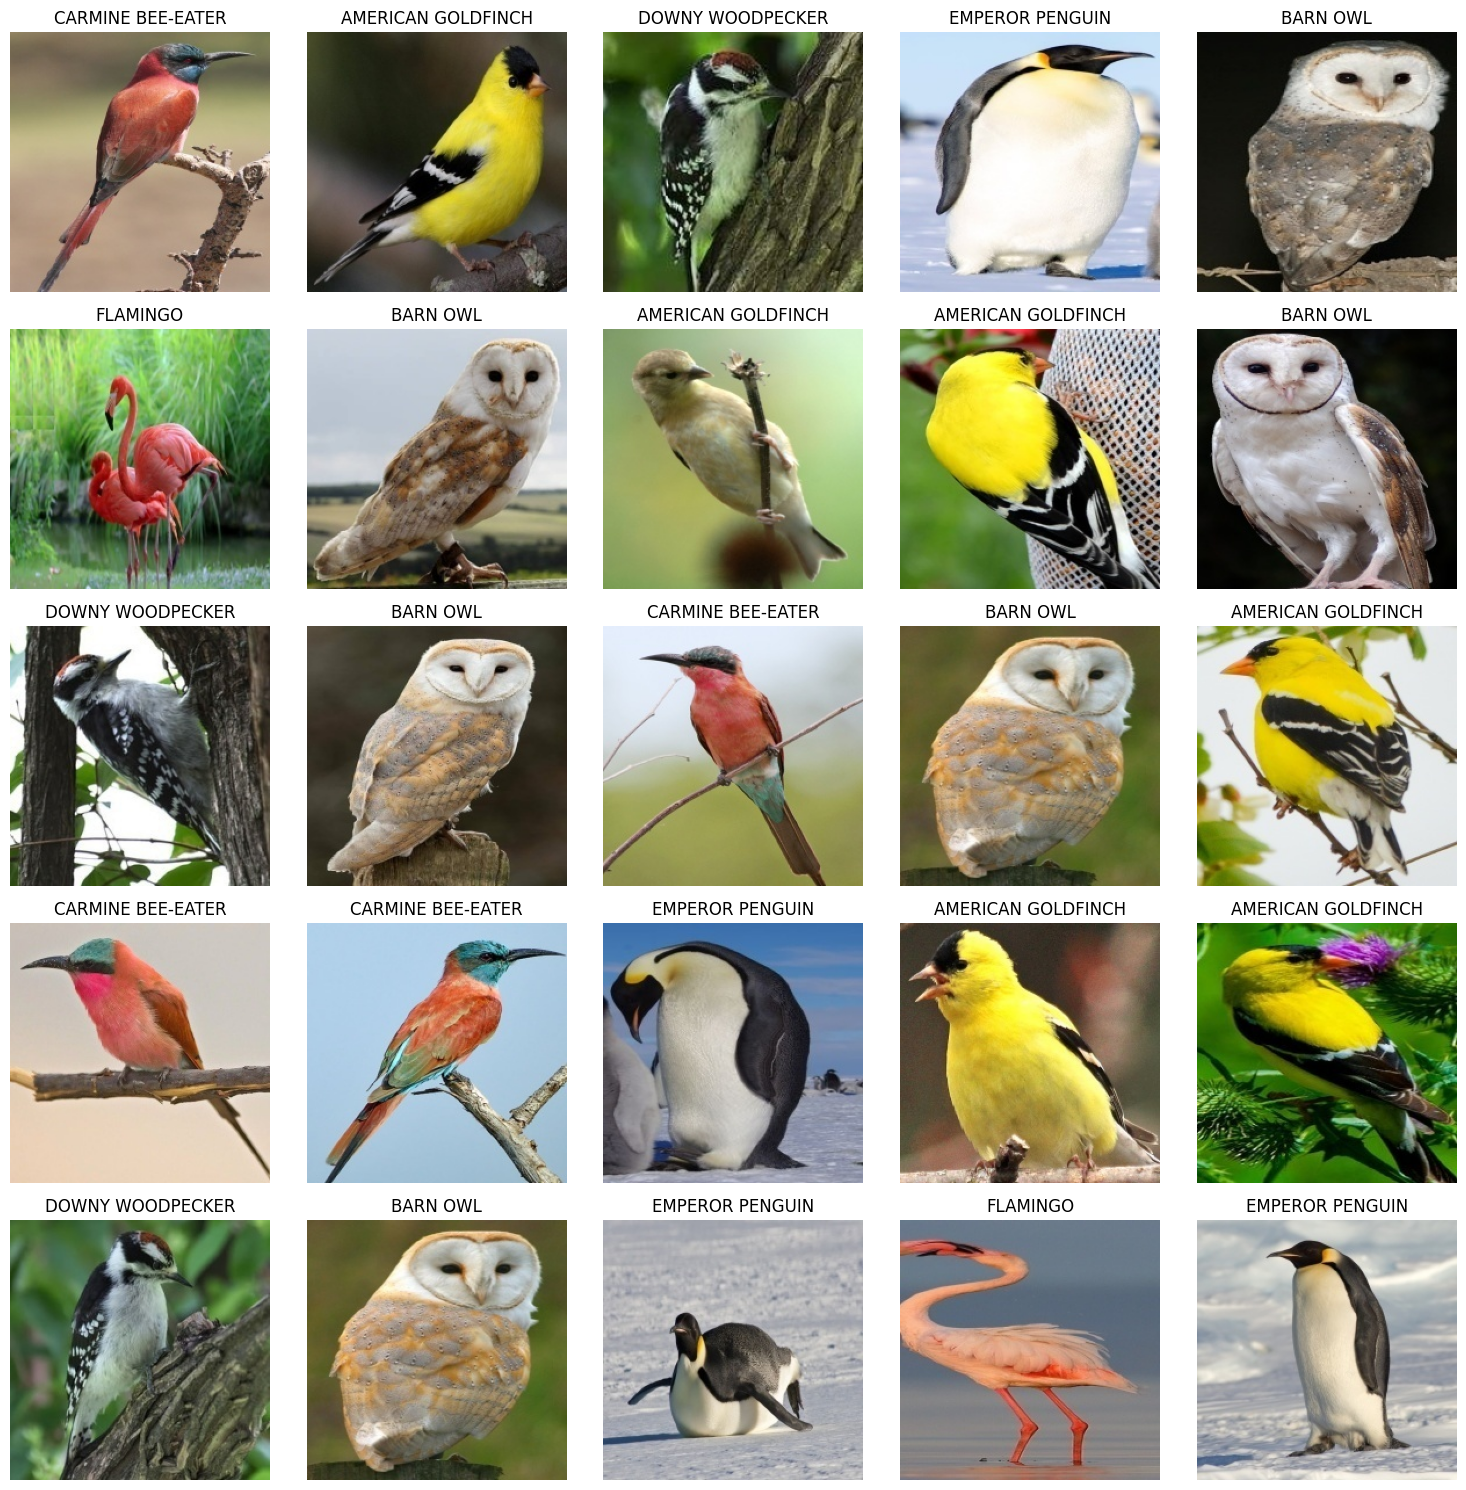

In [3]:
classes = os.listdir(image_path)
samples = []

# Collect at most 25 images from dataset (one per class, random)
for cls in classes:
    cls_path = os.path.join(image_path, cls)
    imgs = os.listdir(cls_path)
    if imgs:
        img_file = random.choice(imgs)
        samples.append((os.path.join(cls_path, img_file), cls))
    if len(samples) >= 25:
        break


while len(samples) < 25:
    cls = random.choice(classes)
    cls_path = os.path.join(image_path, cls)
    imgs = os.listdir(cls_path)
    if imgs:
        img_file = random.choice(imgs)
        samples.append((os.path.join(cls_path, img_file), cls))

fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axs.flatten()):
    img_path, label = samples[i]
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Bird Species Image Distribution 📊

- Here's a clear visualization of how many images each bird species has in the dataset. This helps us understand class balance and focus areas for modeling.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


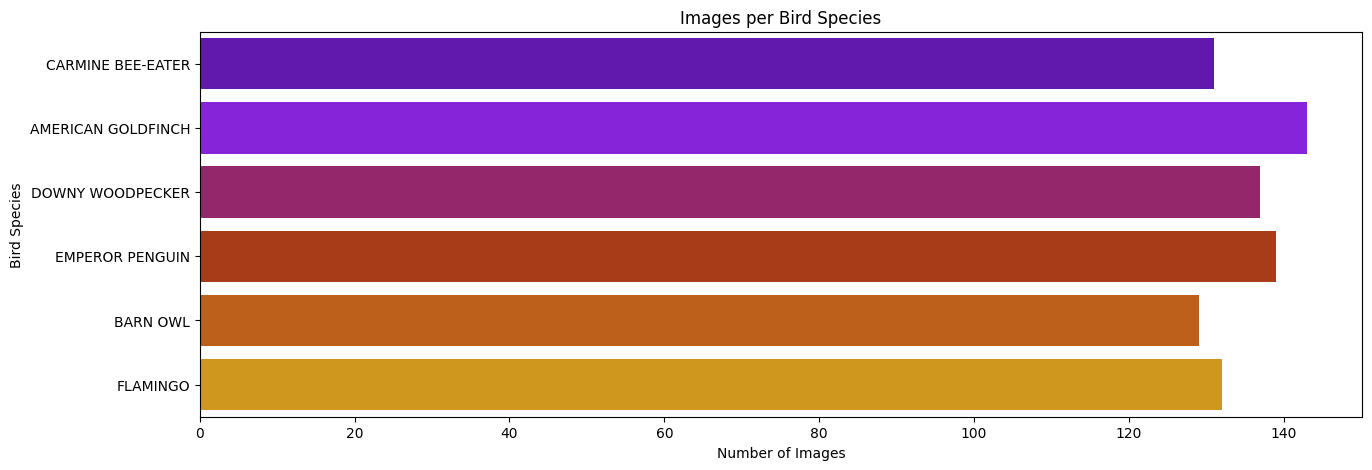

In [4]:
plt.figure(figsize=(15,5))
labels = [folder for folder in os.listdir(image_path) if os.path.isdir(os.path.join(image_path, folder))]
counts = [len(os.listdir(os.path.join(image_path, label))) for label in labels]

sns.barplot(x=counts, y=labels, palette="gnuplot")
plt.xlabel('Number of Images')
plt.ylabel('Bird Species')
plt.title('Images per Bird Species')
plt.show()

# Loading and Inspecting Bird Species Dataset

- Iterate through each species folder
- Read images with OpenCV
- Convert images to arrays
- Skip corrupted/unreadable files
- Count images per species
- Display class distribution summary


In [5]:
base_path = "/kaggle/input/birds-species-prediction/Data/Bird Speciees Dataset"
image_list, label_list = [], []

for species in listdir(base_path):
    species_path = f"{base_path}/{species}"
    for file in listdir(species_path):
        file_path = f"{species_path}/{file}"
        img = cv2.imread(file_path)
        if img is not None:  
            img_array = img_to_array(img)
            image_list.append(img_array)
            label_list.append(species)

label_counts = pd.Series(label_list).value_counts()
print(label_counts)

AMERICAN GOLDFINCH    143
EMPEROR PENGUIN       139
DOWNY WOODPECKER      137
FLAMINGO              132
CARMINE BEE-EATER     131
BARN OWL              129
Name: count, dtype: int64


# Storing number of classes

In [6]:
num_classes = len(label_counts)
num_classes

6

# Checking input image shape

In [7]:
image_list[0].shape

(224, 224, 3)

# Checking labels shape 

In [8]:
label_list = np.array(label_list)
label_list.shape

(811,)

# Splitting dataset

In [9]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 42) 
print("Train set shape:", np.array(x_train).shape)
print("Test set shape:", np.array(x_test).shape)
print("Train labels count:", len(y_train))
print("Test labels count:", len(y_test))

Train set shape: (648, 224, 224, 3)
Test set shape: (163, 224, 224, 3)
Train labels count: 648
Test labels count: 163


# Normalize and reshape data

In [10]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 224,224,3)
x_test = x_test.reshape( -1, 224,224,3)

# Label binarizing

In [11]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['AMERICAN GOLDFINCH' 'BARN OWL' 'CARMINE BEE-EATER' 'DOWNY WOODPECKER'
 'EMPEROR PENGUIN' 'FLAMINGO']


# Splitting the training data set into training and validation data sets

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2,random_state=42)
print("Training set shape:", np.array(x_train).shape)
print("Validation set shape:", np.array(x_val).shape)
print("Training labels count:", len(y_train))
print("Validation labels count:", len(y_val))

Training set shape: (518, 224, 224, 3)
Validation set shape: (130, 224, 224, 3)
Training labels count: 518
Validation labels count: 130


# CNN Model Architecture Overview

This Sequential CNN model is designed for bird species classification with the following layers:

- **Conv2D Layer 1:** 8 filters, 3x3 kernel, 'same' padding, ReLU activation, input shape (224, 224, 3)
- **MaxPooling2D Layer 1:** Pool size 3x3 to reduce spatial dimensions
- **Conv2D Layer 2:** 16 filters, 3x3 kernel, 'same' padding, ReLU activation
- **MaxPooling2D Layer 2:** Pool size 2x2 for downsampling
- **Conv2D Layer 3:** 32 filters, 3x3 kernel, 'same' padding, ReLU activation
- **MaxPooling2D Layer 3:** Pool size 2x2 to further reduce dimensions
- **Flatten Layer:** Converts 2D feature maps to 1D feature vector
- **Dense Layer 1:** 32 neurons with ReLU activation for learning complex patterns
- **Output Layer:** Dense layer with `num_classes` neurons and softmax activation for multi-class classification

Below is the model summary for a clear structural insight.


In [13]:
model = Sequential()
model.add(Conv2D(8, (3, 3), padding="same",input_shape=(224,224,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747857266.302113    6566 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 74, 74, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         331,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 338,038 (1.29 MB)

 Trainable params: 338,038 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

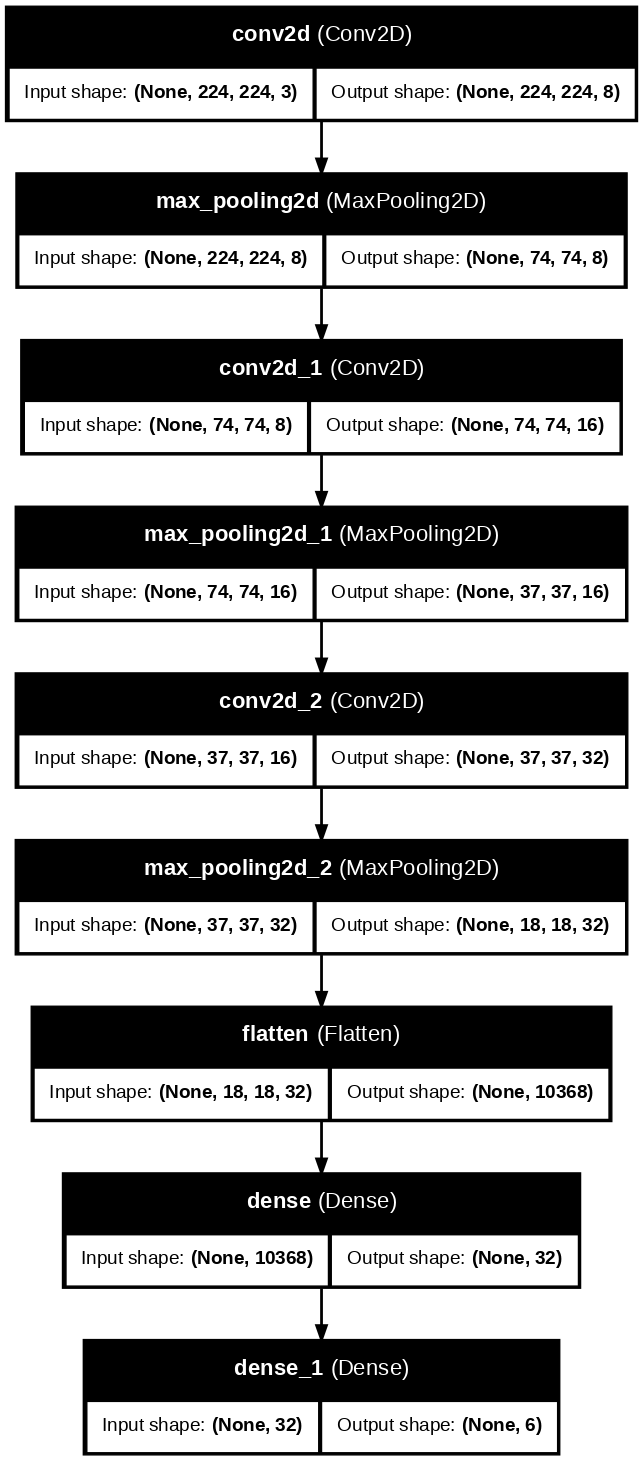

In [14]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=100)


In [15]:
epochs = 100
batch_size = 64
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val),shuffle=True)

Epoch 1/100


I0000 00:00:1747857270.382158    6619 service.cc:148] XLA service 0x7dfcfc004d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747857270.382218    6619 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747857270.590109    6619 cuda_dnn.cc:529] Loaded cuDNN version 90300


7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1798 - loss: 1.8204

I0000 00:00:1747857272.769131    6619 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 391ms/step - accuracy: 0.1824 - loss: 1.8115 - val_accuracy: 0.2154 - val_loss: 1.7626
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2150 - loss: 1.7344 - val_accuracy: 0.3077 - val_loss: 1.7371
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2714 - loss: 1.7203 - val_accuracy: 0.4154 - val_loss: 1.6843
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3657 - loss: 1.6691 - val_accuracy: 0.4077 - val_loss: 1.6669
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3796 - loss: 1.6413 - val_accuracy: 0.3077 - val_loss: 1.6473
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3645 - loss: 1.6047 - val_accuracy: 0.3769 - val_loss: 1.5861
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3918 - loss: 1.5642 - val_accuracy: 0.4385 - val_loss: 1.5563
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4902 - loss: 1.5119 - val_accuracy: 0.4154 - val_loss: 1.5424
Epo

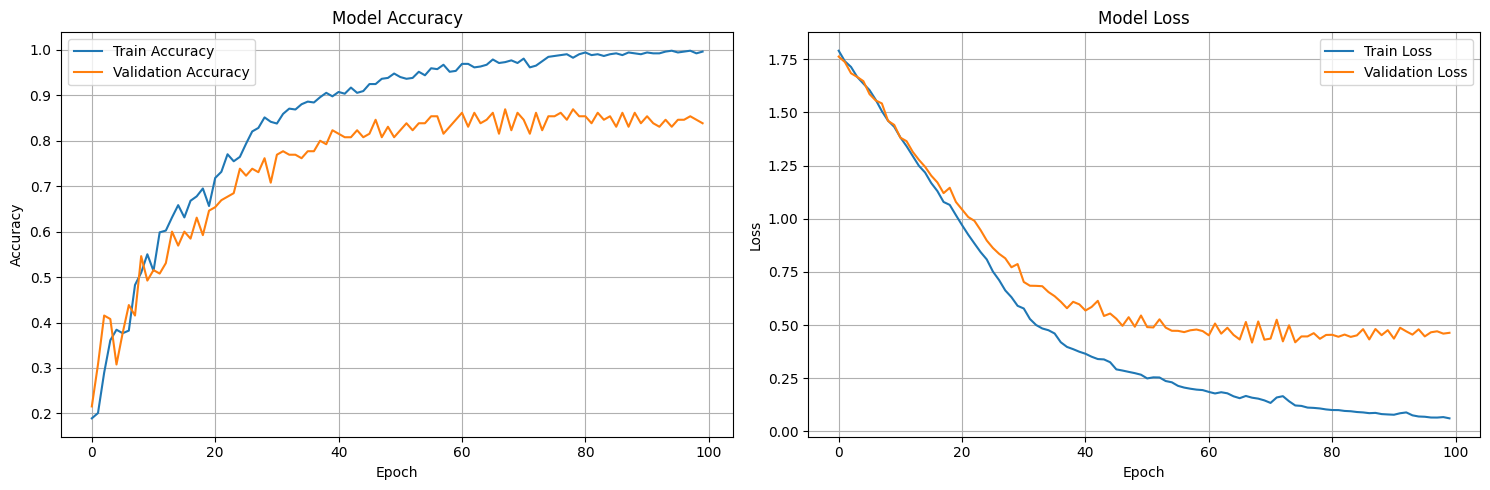

In [16]:
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8778 - loss: 0.3412
Test Accuracy: 0.8589
Test Loss: 0.3912


In [18]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

# Predict probabilities
y_pred_probs = model.predict(x_test)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)  # if one-hot encoded

# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Accuracy : 0.8589
Precision: 0.8675
Recall   : 0.8589
F1 Score : 0.8591


In [19]:
print("Classification Report:")
label_name=['AMERICAN GOLDFINCH','BARN OWL','CARMINE BEE-EATER','DOWNY WOODPECKER','EMPEROR PENGUIN','FLAMINGO']
print(classification_report(y_true_classes, y_pred_classes,target_names=label_name))

Classification Report:
                    precision    recall  f1-score   support

AMERICAN GOLDFINCH       0.96      0.96      0.96        23
          BARN OWL       0.91      0.74      0.82        27
 CARMINE BEE-EATER       0.88      0.79      0.84        29
  DOWNY WOODPECKER       0.88      0.82      0.85        28
   EMPEROR PENGUIN       0.90      1.00      0.95        27
          FLAMINGO       0.69      0.86      0.77        29

          accuracy                           0.86       163
         macro avg       0.87      0.86      0.86       163
      weighted avg       0.87      0.86      0.86       163



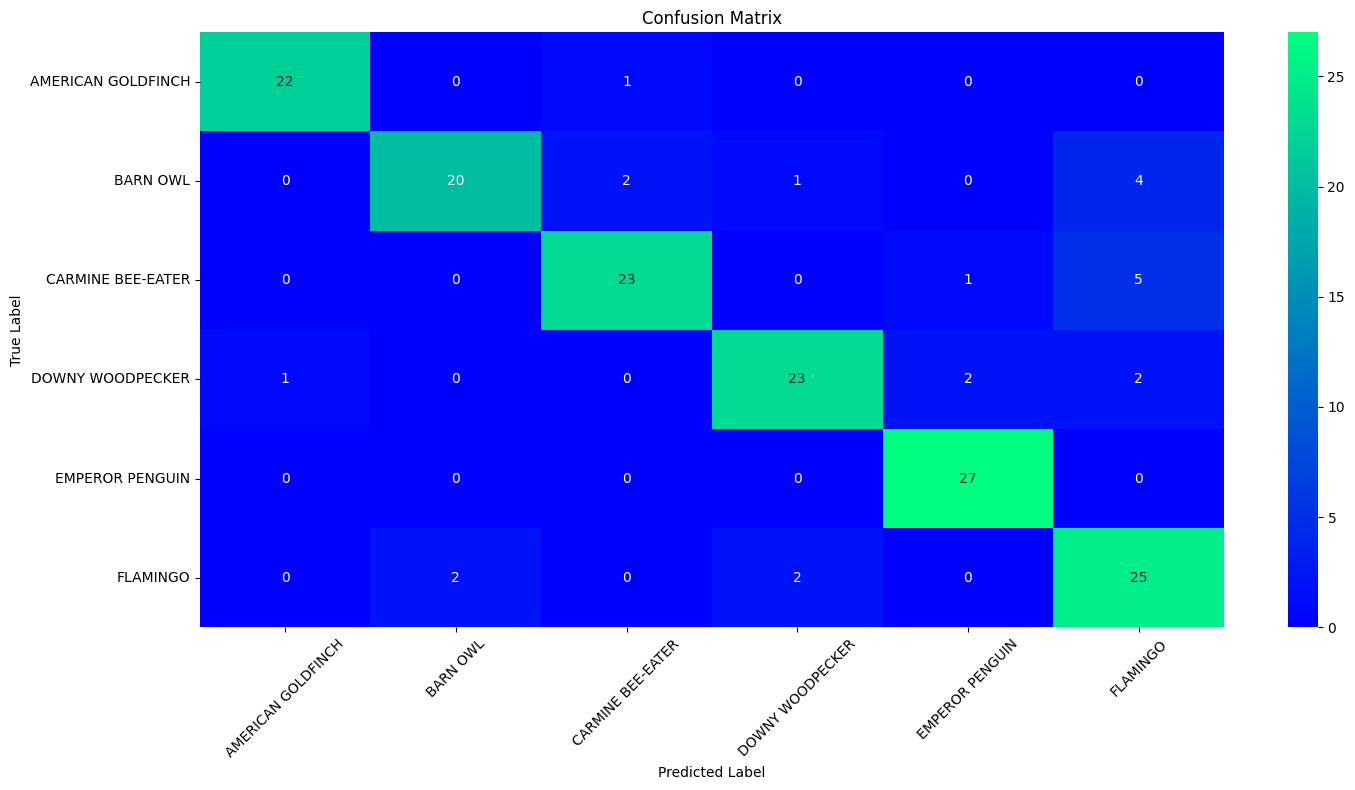

In [20]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='winter', xticklabels=label_name, yticklabels=label_name)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

=== ROC AUC & Precision-Recall Curves for Each Class (Side by Side) ===

Description:
- This script plots two side-by-side figures:
  1. ROC AUC curves for each class with AUC scores
  2. Precision-Recall curves for each class with Average Precision (AP) scores

Requirements:
- y_test must be one-hot encoded
- y_pred_probs must contain predicted probabilities for each class



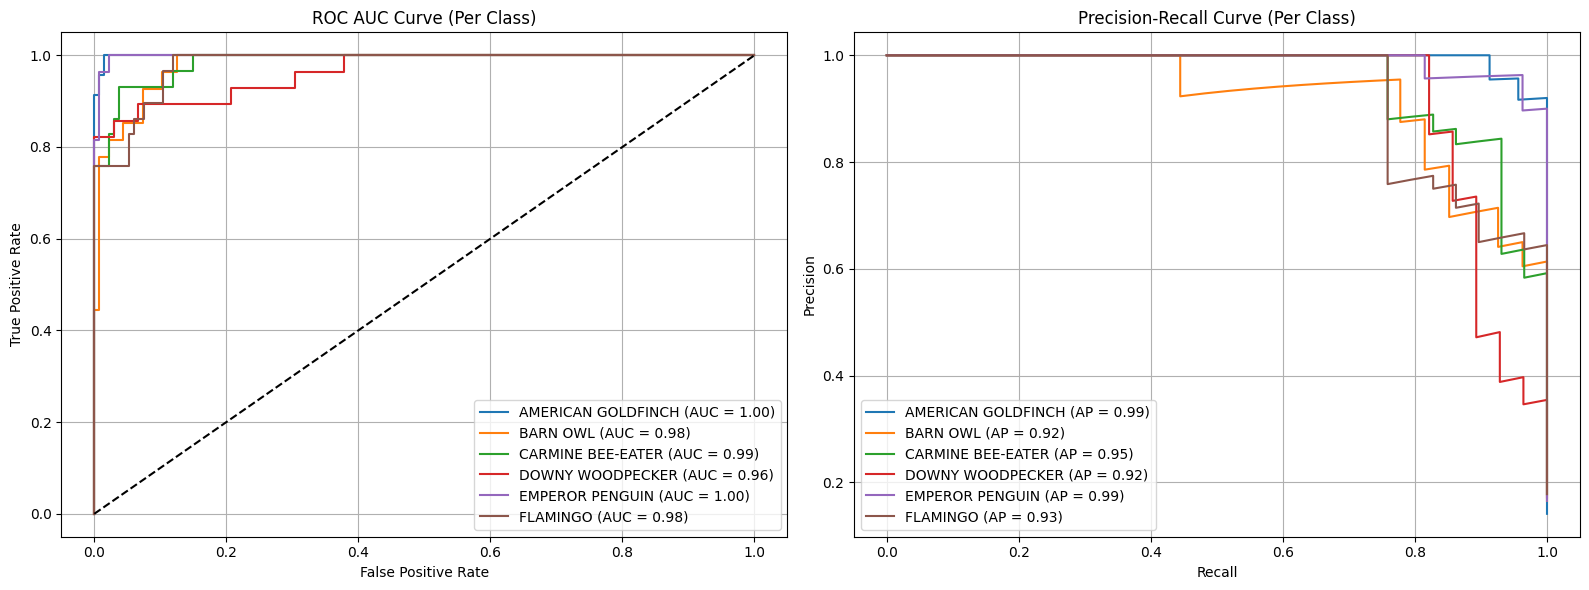

In [21]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Ensure arrays
y_true = np.array(y_test)
y_score = np.array(y_pred_probs)
n_classes = len(label_name)

# Set up plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ----- ROC Curve for each class -----
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f'{label_name[i]} (AUC = {roc_auc:.2f})')

ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_title('ROC AUC Curve (Per Class)')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')
ax1.grid()

# ----- Precision-Recall Curve for each class -----
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_true[:, i], y_score[:, i])
    ax2.plot(recall, precision, label=f'{label_name[i]} (AP = {avg_precision:.2f})')

ax2.set_title('Precision-Recall Curve (Per Class)')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc='lower left')
ax2.grid()

plt.tight_layout()
plt.show()


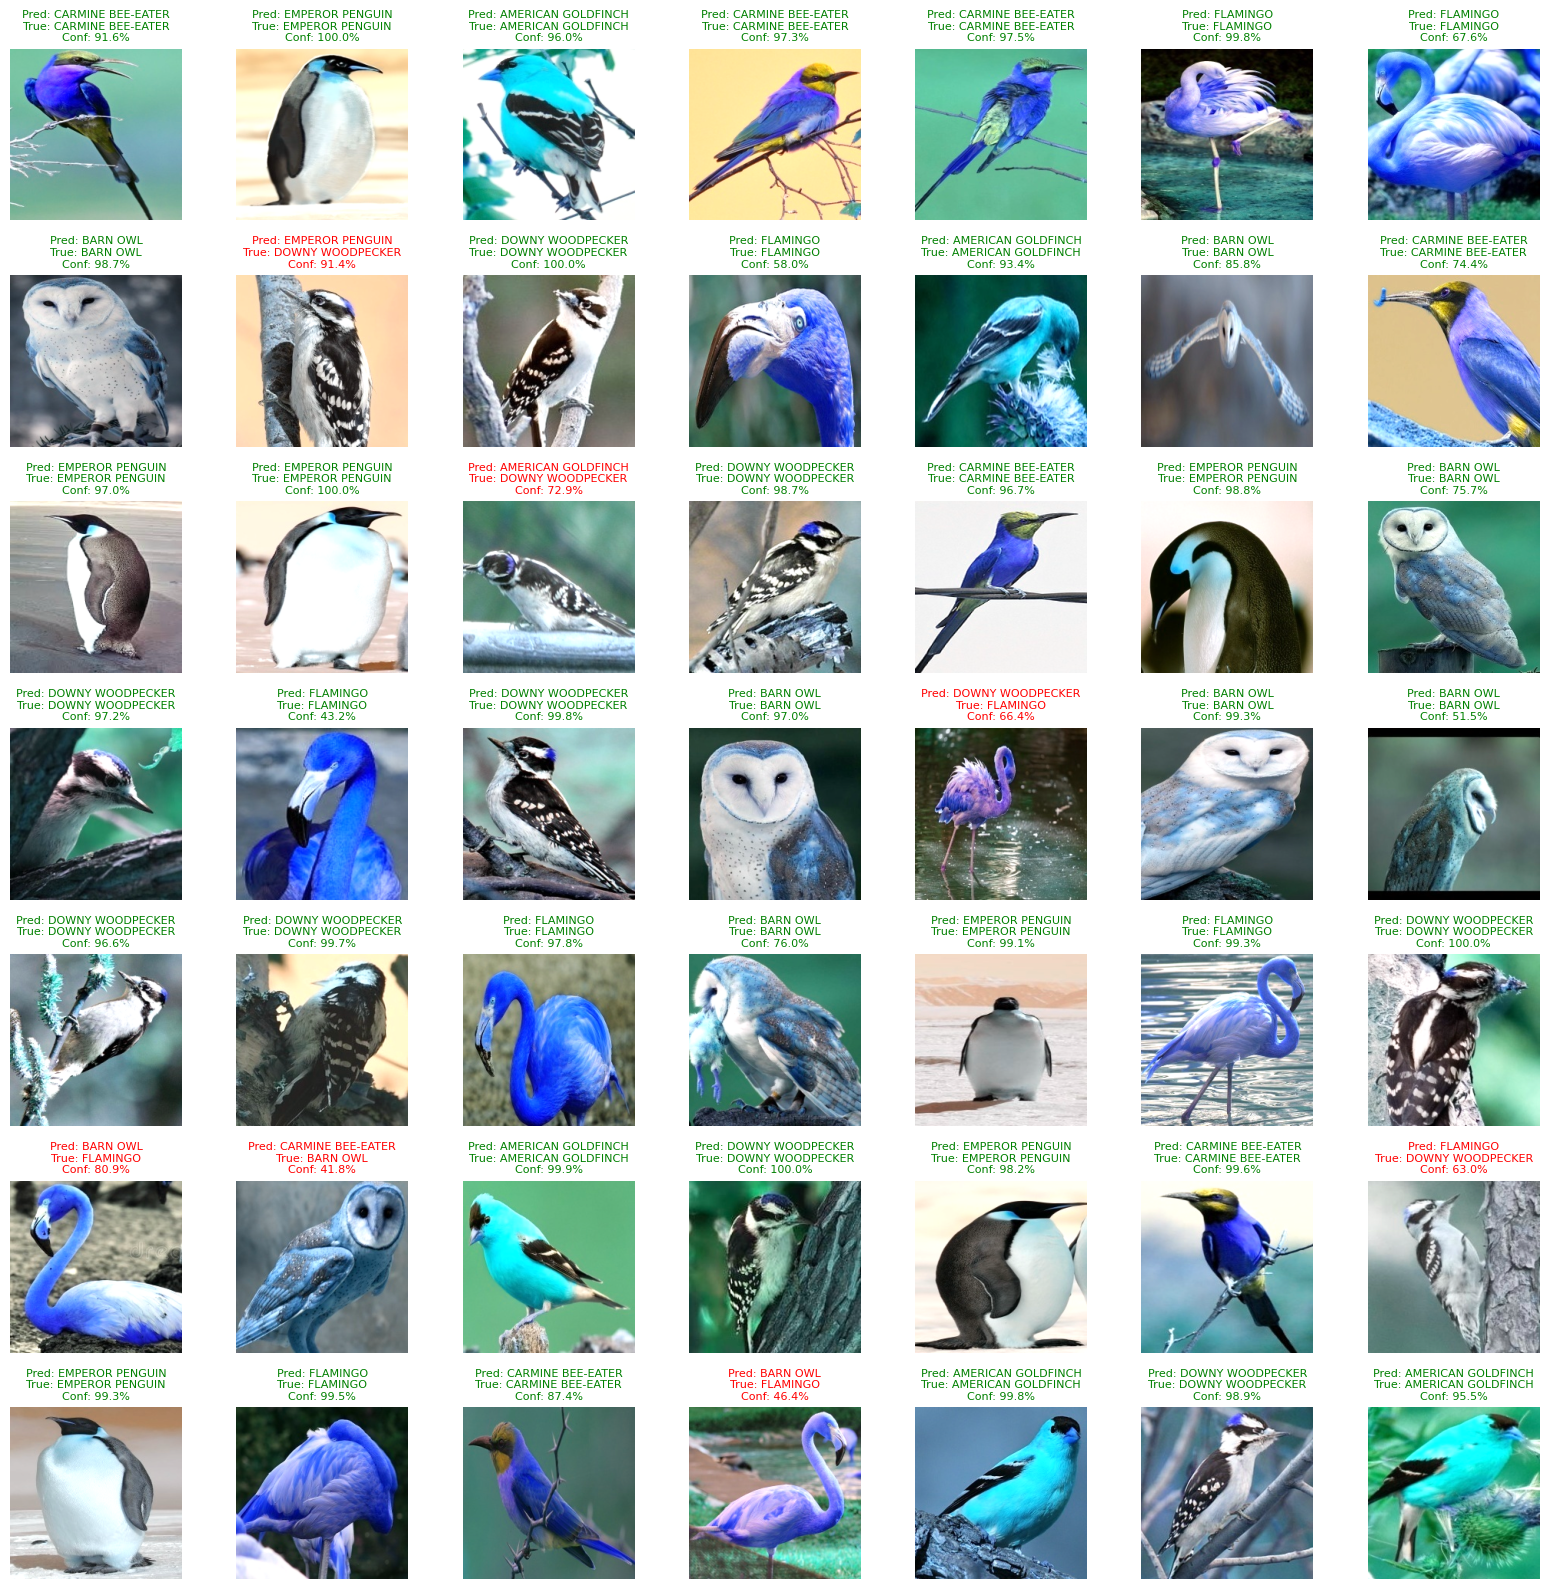

In [22]:
x_plot = x_test.astype('float32')
if x_plot.max() > 10:
    x_plot /= 255.0  # Only scale if needed

plt.figure(figsize=(16, 16))
indices = np.random.choice(len(x_plot), 49, replace=False)

for i, idx in enumerate(indices):
    image = x_plot[idx]
    true_label = np.argmax(y_test[idx])
    pred_probs = y_pred_probs[idx]
    pred_label = np.argmax(pred_probs)
    confidence = np.max(pred_probs) * 100
    correct = (true_label == pred_label)

    plt.subplot(7, 7, i + 1)
    if image.ndim == 2 or (image.ndim == 3 and image.shape[-1] == 1):
        plt.imshow(image.squeeze(), cmap='gray')
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.title(
        f"Pred: {label_name[pred_label]}\nTrue: {label_name[true_label]}\nConf: {confidence:.1f}%",
        color='green' if correct else 'red',
        fontsize=8
    )

plt.tight_layout()
plt.show()


In [23]:
model.save('my_model.keras')


In [24]:
! pip freeze

absl-py==1.4.0
accelerate==1.5.2
aiofiles==22.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.18
aiosignal==1.3.2
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
alembic==1.15.2
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.7.1
arrow==1.3.0
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.3.31.0.36.18
asttokens==3.0.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
bayesian-optimization==2.0.3
beartype==0.20.2
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.2.1
blobfile==3.0.0
blosc2==3.2.1
bokeh==3.6.3
Boruta==0.4.3
boto3==1.38.11
botocore==1.38.11
Bottleneck==1.4.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper